# REINFORCE in PyTorch

Just like we did before for Q-learning, this time we'll design a PyTorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [3]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !pip install -q gym[classic_control]==0.18.0
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.13_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.13) ...
Setting up xvfb (2:1.19.6-1ubuntu4.13) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 1.6 MB 7.0 MB/s 
     |████████████████████████████████| 1.0 MB 60.6 MB/s 
Starting virtual X frame buffer: Xvfb.


In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

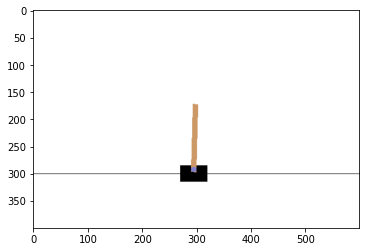

In [5]:
env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

# For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [6]:
import torch
import torch.nn as nn

In [7]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
model = nn.Sequential(
    nn.Linear(state_dim[0], 32),
    nn.ReLU(),
    nn.Linear(32,32),
    nn.ReLU(),
    nn.Linear(32,n_actions)
)

#### Predict function

Note: output value of this function is not a torch tensor, it's a numpy array.
So, here gradient calculation is not needed.
<br>
Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.
<br>
Also, `.detach()` (or legacy `.data` property) can be used instead, but there is a difference:
<br>
With `.detach()` computational graph is built but then disconnected from a particular tensor,
so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
<br>
In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [8]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    states = torch.tensor(states, dtype=torch.float32)
    pi = model(states)
    # print(pi)
    with torch.no_grad():
        action_probs = nn.functional.softmax(pi, dim = 1)

    print(action_probs)
    return action_probs.numpy()

In [9]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_probs(test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

tensor([[0.5671, 0.4329],
        [0.5676, 0.4324],
        [0.5674, 0.4326],
        [0.5687, 0.4313],
        [0.5684, 0.4316]])


### Play the game

We can now use our newly built agent to play the game.

In [10]:
def generate_session(env, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]

        # Sample action with given probabilities.
        # NOTE this is picking a random action (either 0 or 1) based on the the 
        # probabilities defined in action_probs
        a = np.random.choice(2, p=action_probs)

        # Take this new action step
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [11]:
# test it
states, actions, rewards = generate_session(env)

tensor([[0.5681, 0.4319]])
tensor([[0.5709, 0.4291]])
tensor([[0.5723, 0.4277]])
tensor([[0.5721, 0.4279]])
tensor([[0.5730, 0.4270]])
tensor([[0.5726, 0.4274]])
tensor([[0.5741, 0.4259]])
tensor([[0.5732, 0.4268]])
tensor([[0.5745, 0.4255]])
tensor([[0.5737, 0.4263]])
tensor([[0.5713, 0.4287]])
tensor([[0.5681, 0.4319]])
tensor([[0.5695, 0.4305]])
tensor([[0.5684, 0.4316]])
tensor([[0.5718, 0.4282]])
tensor([[0.5690, 0.4310]])
tensor([[0.5682, 0.4318]])
tensor([[0.5699, 0.4301]])
tensor([[0.5677, 0.4323]])
tensor([[0.5694, 0.4306]])
tensor([[0.5674, 0.4326]])
tensor([[0.5689, 0.4311]])
tensor([[0.5673, 0.4327]])
tensor([[0.5684, 0.4316]])
tensor([[0.5691, 0.4309]])
tensor([[0.5686, 0.4314]])
tensor([[0.5691, 0.4309]])
tensor([[0.5683, 0.4317]])
tensor([[0.5696, 0.4304]])
tensor([[0.5687, 0.4313]])
tensor([[0.5704, 0.4296]])
tensor([[0.5725, 0.4275]])
tensor([[0.5714, 0.4286]])
tensor([[0.5733, 0.4267]])


### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [18]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    G, n = rewards.copy(), len(rewards)
    # use bottom up dp to calculate the rewards 
    for i in range(n - 2, -1, -1):
        G[i] = rewards[i] + gamma * G[i+1]

    return G

In [19]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [20]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [21]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forget entropy regularization with `entropy_coef` 
    N = len(states)
    entropy = torch.sum(probs * log_probs)
    J_hat = torch.mean(log_probs_for_actions * cumulative_returns)

    loss = -(J_hat + entropy_coef*entropy)

    # Gradient descent step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [22]:
for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # generate new sessions
    
    print("mean reward:%.3f" % (np.mean(rewards)))
    
    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

tensor([[0.5674, 0.4326]])
tensor([[0.5700, 0.4300]])
tensor([[0.5674, 0.4326]])
tensor([[0.5701, 0.4299]])
tensor([[0.5675, 0.4325]])
tensor([[0.5689, 0.4311]])
tensor([[0.5706, 0.4294]])
tensor([[0.5711, 0.4289]])
tensor([[0.5700, 0.4300]])
tensor([[0.5708, 0.4292]])
tensor([[0.5699, 0.4301]])
tensor([[0.5702, 0.4298]])
tensor([[0.5698, 0.4302]])
tensor([[0.5720, 0.4280]])
tensor([[0.5746, 0.4254]])
tensor([[0.5702, 0.4298]])
tensor([[0.5720, 0.4280]])
tensor([[0.5746, 0.4254]])
tensor([[0.5752, 0.4248]])
tensor([[0.5749, 0.4251]])
tensor([[0.5762, 0.4238]])
tensor([[0.5792, 0.4208]])
tensor([[0.5826, 0.4174]])
tensor([[0.5740, 0.4260]])
tensor([[0.5758, 0.4242]])
tensor([[0.5784, 0.4216]])
tensor([[0.5795, 0.4205]])
tensor([[0.5784, 0.4216]])
tensor([[0.5757, 0.4243]])
tensor([[0.5786, 0.4214]])
tensor([[0.5793, 0.4207]])
tensor([[0.5796, 0.4204]])
tensor([[0.5791, 0.4209]])
tensor([[0.5798, 0.4202]])
tensor([[0.5821, 0.4179]])
tensor([[0.5781, 0.4219]])
tensor([[0.5807, 0.4193]])
t

<ipython-input-21-dde6030f4e2e>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  states = torch.tensor(states, dtype=torch.float32)


Streaming output truncated to the last 5000 lines.
tensor([[0.0134, 0.9866]])
tensor([[0.8870, 0.1130]])
tensor([[0.0119, 0.9881]])
tensor([[0.8752, 0.1248]])
tensor([[0.0106, 0.9894]])
tensor([[0.8632, 0.1368]])
tensor([[0.0096, 0.9904]])
tensor([[0.8506, 0.1494]])
tensor([[0.0088, 0.9912]])
tensor([[0.8371, 0.1629]])
tensor([[9.9933e-01, 6.7461e-04]])
tensor([[0.8494, 0.1506]])
tensor([[0.0092, 0.9908]])
tensor([[0.8563, 0.1437]])
tensor([[0.0095, 0.9905]])
tensor([[0.8629, 0.1371]])
tensor([[0.0099, 0.9901]])
tensor([[0.8692, 0.1308]])
tensor([[0.0102, 0.9898]])
tensor([[0.8754, 0.1246]])
tensor([[0.0106, 0.9894]])
tensor([[0.8816, 0.1184]])
tensor([[0.0111, 0.9889]])
tensor([[0.8881, 0.1119]])
tensor([[0.0116, 0.9884]])
tensor([[0.8950, 0.1050]])
tensor([[0.0122, 0.9878]])
tensor([[0.9002, 0.0998]])
tensor([[0.0129, 0.9871]])
tensor([[0.9049, 0.0951]])
tensor([[0.0137, 0.9863]])
tensor([[0.9101, 0.0899]])
tensor([[0.0147, 0.9853]])
tensor([[6.3028e-04, 9.9937e-01]])
tensor([[0.0135

### Results & video

In [23]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(100)]

Streaming output truncated to the last 5000 lines.
tensor([[0.2775, 0.7225]])
tensor([[0.9980, 0.0020]])
tensor([[0.2372, 0.7628]])
tensor([[0.9979, 0.0021]])
tensor([[0.2172, 0.7828]])
tensor([[0.9978, 0.0022]])
tensor([[0.2137, 0.7863]])
tensor([[0.9978, 0.0022]])
tensor([[0.2259, 0.7741]])
tensor([[0.9979, 0.0021]])
tensor([[0.2558, 0.7442]])
tensor([[0.9981, 0.0019]])
tensor([[0.3082, 0.6918]])
tensor([[0.9984, 0.0016]])
tensor([[0.3899, 0.6101]])
tensor([[0.0031, 0.9969]])
tensor([[0.4449, 0.5551]])
tensor([[0.0033, 0.9967]])
tensor([[0.4770, 0.5230]])
tensor([[0.0034, 0.9966]])
tensor([[0.4863, 0.5137]])
tensor([[0.0034, 0.9966]])
tensor([[0.4730, 0.5270]])
tensor([[0.0033, 0.9967]])
tensor([[0.4374, 0.5626]])
tensor([[0.9987, 0.0013]])
tensor([[0.4391, 0.5609]])
tensor([[0.0031, 0.9969]])
tensor([[0.4102, 0.5898]])
tensor([[0.0029, 0.9971]])
tensor([[0.3596, 0.6404]])
tensor([[0.0027, 0.9973]])
tensor([[0.2907, 0.7093]])
tensor([[0.9981, 0.0019]])
tensor([[0.2554, 0.7446]])
tens

In [24]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
        with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))